### Pose Keypoint Head Demo

In [1]:
%load_ext autoreload
%autoreload 2

import json
from omegaconf import OmegaConf
import torch
from tqdm import tqdm

import sys
sys.path.append("../")
from readout_pose import train_pose
from readout_training import train_helpers
from readout_pose import annotate_pose, pose_helpers

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 1.13.1+cu117)
    Python  3.8.16 (you have 3.8.5)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


**Load the Diffusion Extractor and Readout Head**

The demo is pre-loaded to the SDv1-5 pose keypoint readout head.

In [2]:
device = "cuda"
config = OmegaConf.load("configs/annotate_pose.yaml")
batch_size = config["batch_size"]
size = (config["res"], config["res"])
_, diffusion_extractor, aggregation_network = train_helpers.load_models(ckpt_path=config["aggregation_ckpt"])
aggregation_network = aggregation_network.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: generation
idxs: None
output_resolution: 64
prompt: 
negative_prompt: 
save_mode: hidden
Using output head with 18 channels


In [3]:
if "detector_ckpt" in config:
    from ultralytics import YOLO
    detector = YOLO(config["detector_ckpt"], task='detect')
else:
    detector = None

**Estimate the Pose with the Readout Head**

Set the paths to the images you would like to estimate the pose of! If you would like to run the readout head on a large set of images, try adjusting the input folder `read_root` in `annotate_pose.yaml` and running `annotate_pose.py`.

In [4]:
# Images with single person
# paths = [
#     "data/raw/MSCOCO/images/val2017/000000023126.jpg", 
#     "data/raw/MSCOCO/images/val2017/000000485027.jpg",
#     "data/raw/MSCOCO/images/val2017/000000375493.jpg", 
#     "data/raw/MSCOCO/images/val2017/000000352760.jpg",
#     "data/raw/MSCOCO/images/val2017/000000273760.jpg",
# ]

# Images with multiple people
paths = [
    "data/raw/MSCOCO/images/val2017/000000309964.jpg",
    "data/raw/MSCOCO/images/val2017/000000192670.jpg",
    "data/raw/MSCOCO/images/val2017/000000070739.jpg",
    "data/raw/MSCOCO/images/val2017/000000086956.jpg",
    "data/raw/MSCOCO/images/val2017/000000133969.jpg",
]

  0%|          | 0/1 [00:00<?, ?it/s]


0: 512x512 2 persons, 8.8ms
1: 512x512 6 persons, 8.8ms
2: 512x512 3 persons, 8.8ms
3: 512x512 3 persons, 8.8ms
4: 512x512 14 persons, 8.8ms
Speed: 0.0ms preprocess, 8.8ms inference, 25.3ms postprocess per image at shape (1, 3, 512, 512)


../dhf/aggregation_network.py:219: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


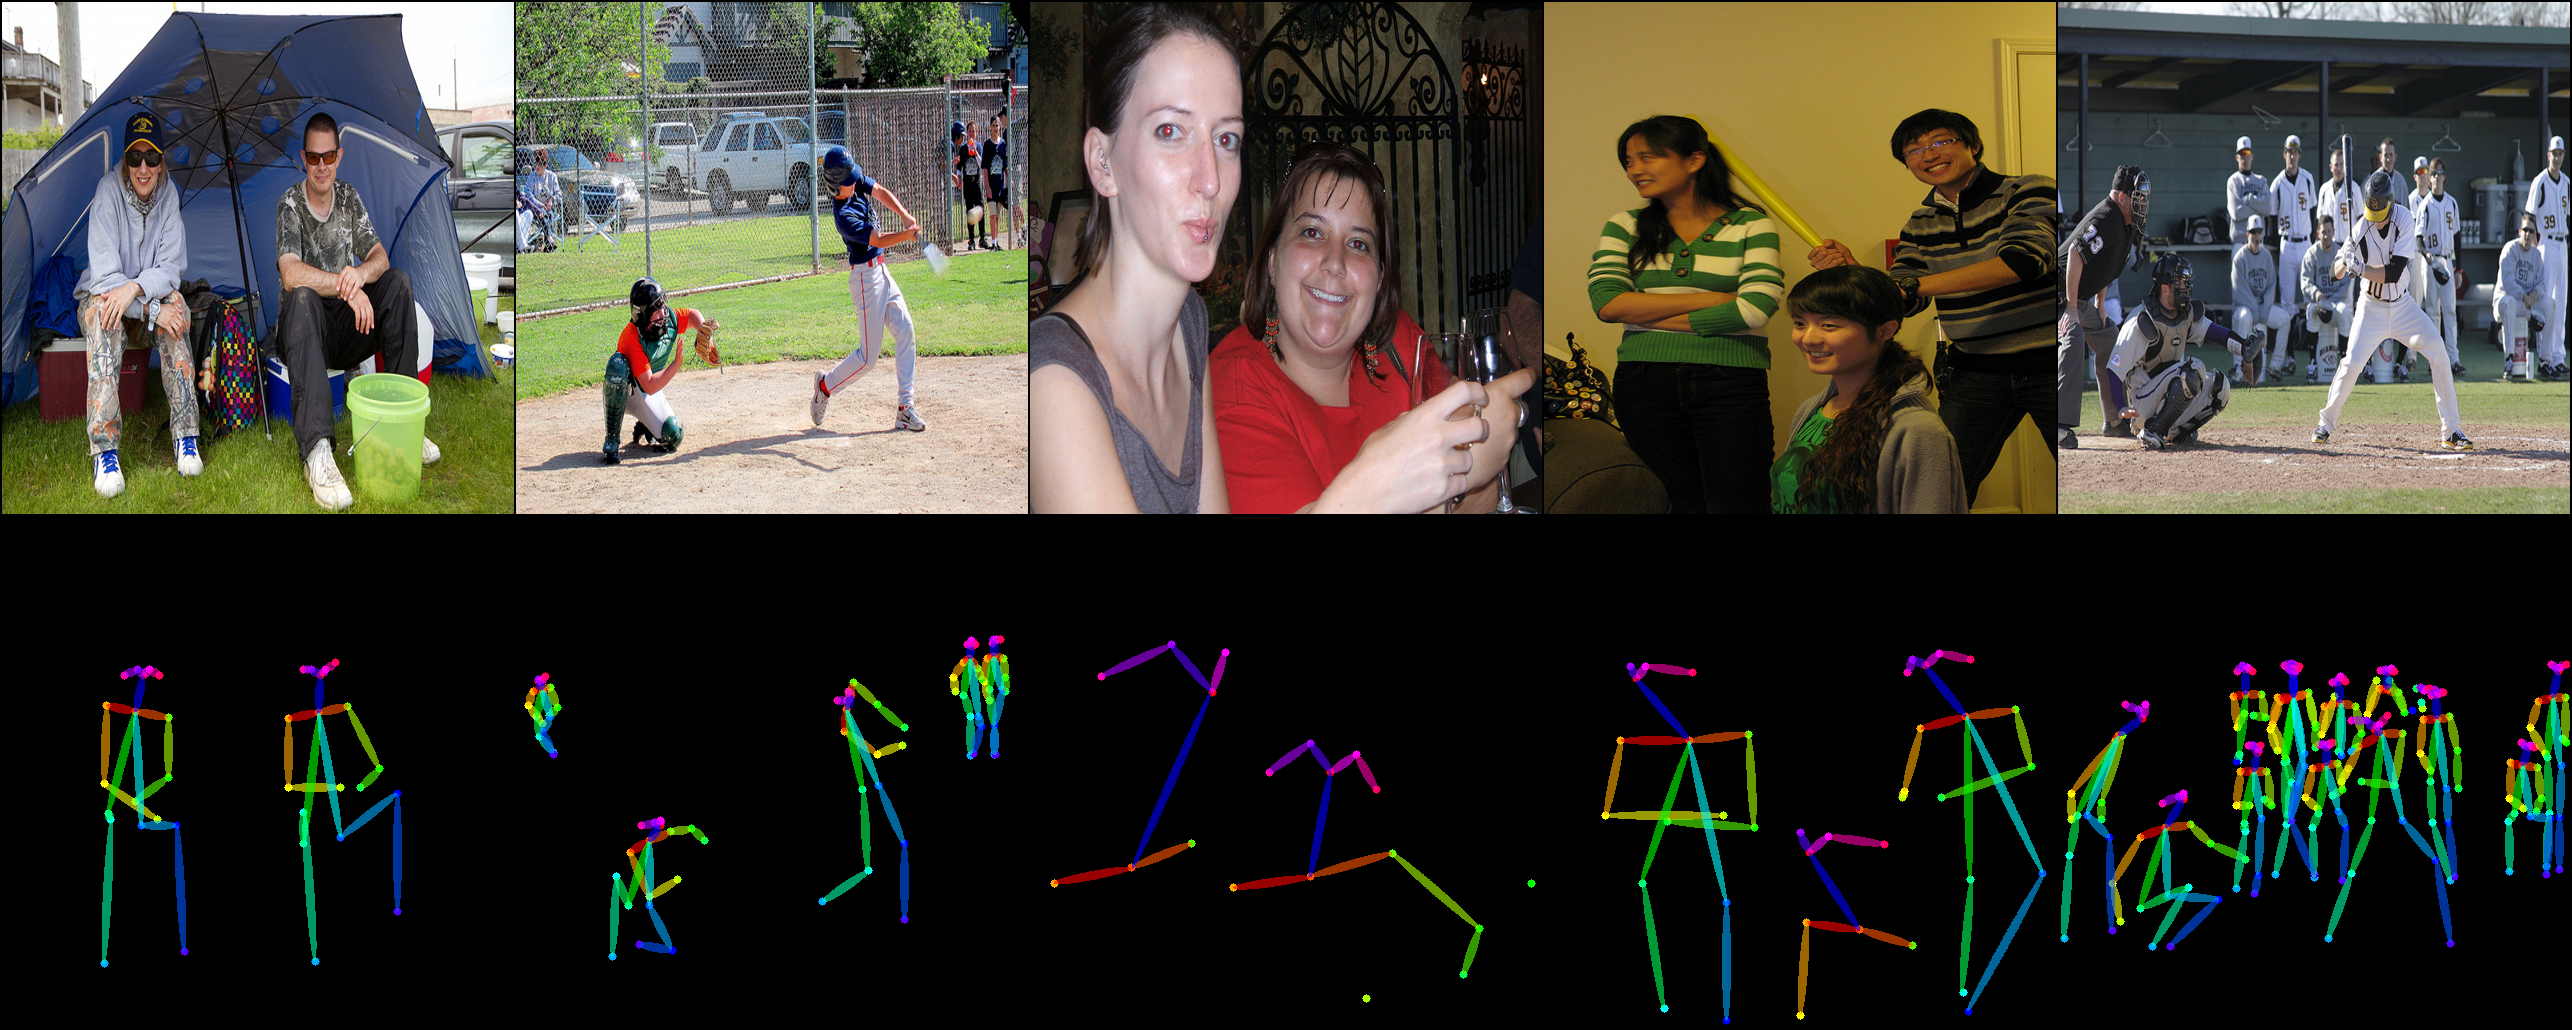

100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


In [8]:
for i in tqdm(range(0, len(paths), batch_size)):
    batch_paths = paths[i:i+batch_size]
    batch = annotate_pose.create_batch(batch_paths, size, device)
    with torch.no_grad():
        imgs = batch["source"]
        if detector is not None:
            bboxes = annotate_pose.get_bboxes(detector, imgs)
        else:
            bboxes = None
        pred_meta = annotate_pose.get_pose(diffusion_extractor, aggregation_network, imgs, size, eval_mode=True, bboxes=bboxes)
        control = train_pose.draw_meta(imgs, pred_meta)
    grid = train_helpers.log_grid(imgs=imgs, pred=control, control_range=(0, 255))
    display(grid)